In [1]:
# http://geotiff.maptools.org/STDI-0002_v2.1.pdf (Section 8.4.2)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import xarray as xr
import os
from scipy.optimize import curve_fit

In [3]:
# Open GOES-17 NetCDF file
g17_b02 = xr.open_dataset('/home/jovyan/goes17/2018/12/12/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G17_s20183461802189_e20183461804562_c20183461805005.nc')

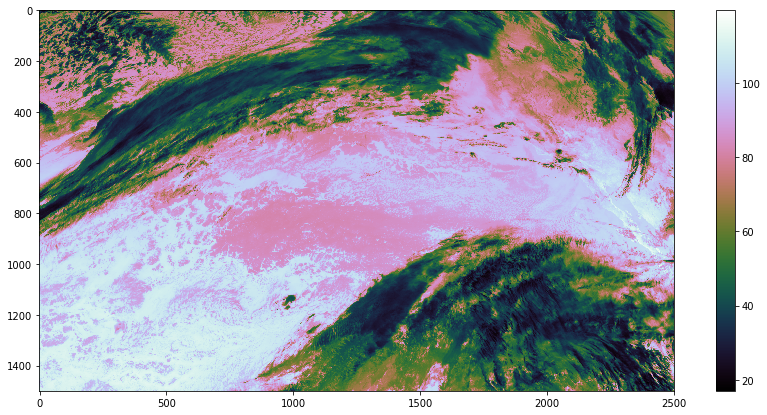

In [38]:
plt.figure(figsize=(15,7))
plt.imshow(g17_b02.Rad,cmap='cubehelix')
plt.colorbar()

In [4]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0 - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lat,lon)



In [5]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(g17_b02.x.values, g17_b02.y.values)

# Values needed for geometry calculations
req = g17_b02.goes_imager_projection.semi_major_axis # semi major axis
rpol = g17_b02.goes_imager_projection.semi_minor_axis
H = g17_b02.goes_imager_projection.perspective_point_height + g17_b02.goes_imager_projection.semi_major_axis
lon_0 = g17_b02.goes_imager_projection.longitude_of_projection_origin

# Get lat and lon values
lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)


In [6]:
# Pixel coordinates of x and y:
xs = np.linspace(0,g17_b02.x.shape[0],g17_b02.x.shape[0],dtype='int16')
ys = np.linspace(0,g17_b02.y.shape[0],g17_b02.y.shape[0],dtype='int16')
x, y = np.meshgrid(xs,ys)

In [7]:
# Normalize latitude to [-1,1]:
LAT_OFF = lat.min()
LAT_SCALE = lat.max() - lat.min()
lat_norm = 2 * ((lat - LAT_OFF) / LAT_SCALE) - 1

# Normalize longitude to [-1,1]:
LON_OFF = lon.min()
LON_SCALE = lon.max() - lon.min()
lon_norm = 2 * ((lon - LON_OFF) / LON_SCALE) - 1

# Normalize row (y) to [-1,1]:
Y_OFF = y.min()
Y_SCALE = y.max() - y.min()
y_norm = 2 * ((y - Y_OFF) / Y_SCALE) - 1

# Normalize column (x) to [-1,1]:
X_OFF = x.min()
X_SCALE = x.max() - x.min()
x_norm = 2 * ((x - X_OFF) / X_SCALE) - 1

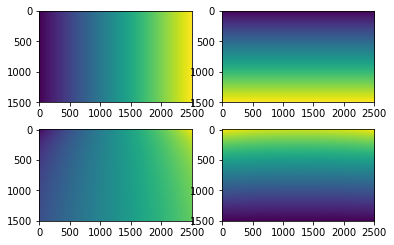

In [31]:
# Visualize the arrays of x, y (scan angle radians), and longitude, latitude (degrees)
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_norm)
ax[0,1].imshow(y_norm)
ax[1,0].imshow(lon_norm)
ax[1,1].imshow(lat_norm)

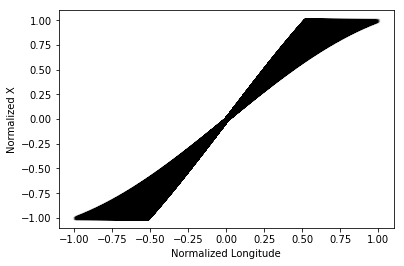

In [39]:
# Visualize longitude (degrees) vs x (pixel coord)
plt.plot(lon_norm,x_norm,'.k',alpha=0.01);
plt.xlabel('Normalized Longitude');
plt.ylabel('Normalized X');

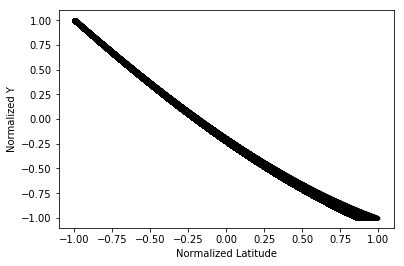

In [12]:
# Visualize latitude (degrees) vs y (pixel coord)
plt.plot(lat_norm,y_norm,'.k',alpha=0.01);
plt.xlabel('Normalized Latitude');
plt.ylabel('Normalized Y');

In [250]:
# Fit RPCs to these two surfaces:
# https://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting
# http://geotiff.maptools.org/STDI-0002_v2.1.pdf (Section 8.4.2)

In [40]:
def map2rpc(in_xyz,
            a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,
            b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19):
    
    x, y, z = in_xyz
    
    num_l = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + a6*y*z + a7*x**2 + a8*y**2 + a9*z**2 + a10*x*y*z + a11*x**3 + a12*x*y**2 + \
    a13**x*z**2 + a14*y*x**2 + a15*y**3 + a16*y*z**2 + a17*x**2*z + a18*y**2*z + a19*z**3
    
    den_l = b0 + b1*x + b2*y + b3*z + b4*x*y + b5*x*z + b6*y*z + b7*x**2 + b8*y**2 + b9*z**2 + b10*x*y*z + b11*x**3 + b12*x*y**2 + \
    b13**x*z**2 + b14*y*x**2 + b15*y**3 + b16*y*z**2 + b17*x**2*z + b18*y**2*z + b19*z**3
    
    return num_l/den_l

In [70]:
# set elevations to 0, on the surface of the ellipsoid??
z_norm = np.zeros_like(lat_norm)

In [102]:
# Pick out n random indices to use for fitting
n = 10000
idx1 = np.random.randint(0, z_norm.shape[0], n)
idx2 = np.random.randint(0, z_norm.shape[0], n)

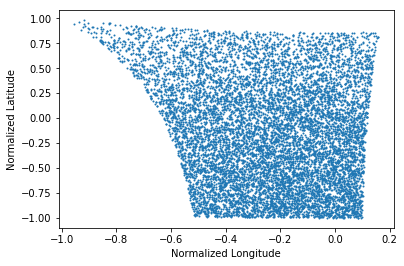

In [103]:
# random lat/lon points:
plt.scatter(lon_norm[idx1,idx2].flatten(),lat_norm[idx1,idx2].flatten(),s=1)
plt.xlabel('Normalized Longitude');
plt.ylabel('Normalized Latitude');

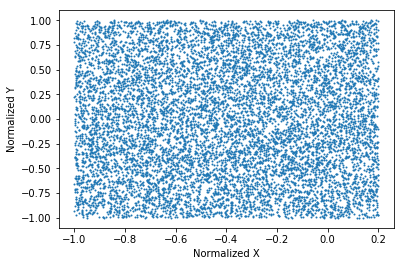

In [104]:
# corresponding random x/y points
plt.scatter(x_norm[idx1,idx2].flatten(),y_norm[idx1,idx2].flatten(),s=1)
plt.xlabel('Normalized X');
plt.ylabel('Normalized Y');

In [105]:
# can try map2rpc or mat2rpc_test, which solves for only 20 of the 40 coefficients
a = curve_fit(map2rpc, 
              (lon_norm[idx1,idx2].flatten(), lat_norm[idx1,idx2].flatten() ,z_norm[idx1,idx2].flatten()), 
              x_norm[idx1,idx2].flatten())

a

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]), array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]))

In [106]:
b = curve_fit(map2rpc, 
              (lon_norm[idx1,idx2].flatten(), lat_norm[idx1,idx2].flatten() ,z_norm[idx1,idx2].flatten()), 
              y_norm[idx1,idx2].flatten())

b

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]), array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]))

/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


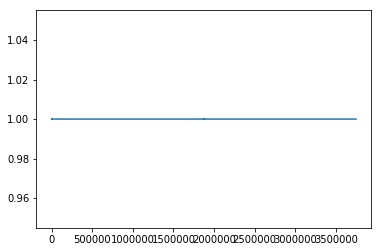

In [109]:
fit_x = map2rpc((x_norm.flatten(),y_norm.flatten(),z_norm.flatten()),*a[0])
plt.plot(fit_x)

/home/jovyan/my-conda-envs/goes/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


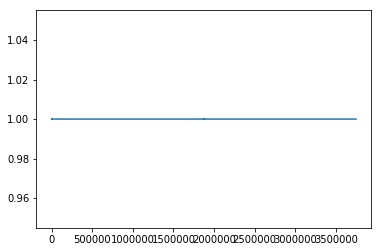

In [110]:
fit_y = map2rpc((x_norm.flatten(),y_norm.flatten(),z_norm.flatten()),*b[0])
plt.plot(fit_y)

***
***

In [111]:
############# fake data testing
def map2rpc_test(in_xyz,
            a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19):
    
    x, y, z = in_xyz
    
    solution = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + a6*y*z + a7*x**2 + a8*y**2 + a9*z**2 + a10*x*y*z + a11*x**3 + a12*x*y**2 + \
    a13**x*z**2 + a14*y*x**2 + a15*y**3 + a16*y*z**2 + a17*x**2*z + a18*y**2*z + a19*z**3
    
    return solution

In [115]:
n = 10000
x = np.linspace(0,1, n)
y = np.linspace(0,1, n)
z = np.linspace(0,1, n)
a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19 = np.random.randint(0,5,20)
#b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19 = np.random.randint(0,5,20)
true_coeffs = np.array([a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19])
# true values of all these coefficients
true = map2rpc_test((x,y,z),a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19)
noisy = true  + ( np.random.random(n) - np.random.random(n) ) / 1

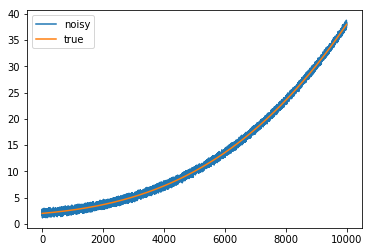

In [116]:
plt.plot(noisy,label='noisy')
plt.plot(true,label='true')
plt.legend()

In [117]:
popt, pcov = curve_fit(map2rpc_test, (x,y,z), noisy, bounds=(-5,5))
print(popt, pcov)

[ 2.17476107 -4.69742222  3.61889468  4.9926787   2.69281553  2.76400412
  2.4834923   2.92047773  1.62728888  1.29957673  1.72094974  2.06855393
  2.09268429  1.4824369   1.81456353  1.77514063  1.80034814  1.77427147
  1.80881572  1.79009527] [[ 1.50554755e+00  5.15982910e+00  4.32436841e-01  1.85187586e+00
  -4.86347601e+00 -3.29610597e-01 -6.03410299e+00  1.13267690e+01
  -1.58788808e+01  7.44438034e+00 -1.68733311e+01 -6.39059043e+00
   1.42667540e-01  6.44328924e-02 -1.31022391e+00 -6.64355985e+00
   6.23572225e+00 -2.08108149e+01  1.15535123e+00  9.64876695e+00]
 [-2.08991367e+09 -3.05821437e+09 -2.60702990e+09 -2.20267882e+09
   1.71455699e+09 -7.44410477e+09 -1.12588993e+10  1.79605936e+10
  -5.48546114e+09 -7.97314109e+08  8.59483774e+09  1.04411954e+10
  -1.89049163e+08  9.58653258e+07 -5.16386386e+08  8.18652025e+08
  -5.36340412e+08 -7.78129974e+08 -1.06095275e+09 -1.53830017e+09]
 [-3.07342110e+09 -2.16358370e+09 -3.89760987e+09 -2.45295408e+09
   3.71162219e+08  6.145467

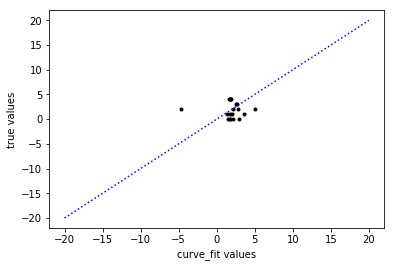

In [118]:
plt.plot(popt,true_coeffs,'.k')
plt.ylabel('true values')
plt.xlabel('curve_fit values')
plt.plot([-20,20],[-20,20],':b')

In [119]:
popt

array([ 2.17476107, -4.69742222,  3.61889468,  4.9926787 ,  2.69281553,
        2.76400412,  2.4834923 ,  2.92047773,  1.62728888,  1.29957673,
        1.72094974,  2.06855393,  2.09268429,  1.4824369 ,  1.81456353,
        1.77514063,  1.80034814,  1.77427147,  1.80881572,  1.79009527])

In [120]:
true_coeffs

array([2, 2, 1, 2, 3, 2, 3, 0, 4, 1, 4, 1, 0, 0, 4, 0, 4, 1, 0, 4])

In [121]:
fit = map2rpc_test((x,y,z),*popt)

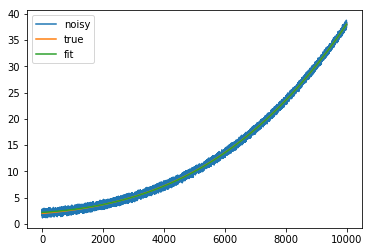

In [122]:
plt.plot(noisy,label="noisy")
plt.plot(true,label="true")
plt.plot(fit,label="fit")
plt.legend()

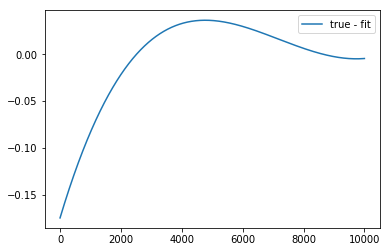

In [123]:
#plt.plot(true - noisy,label="true - noisy")
plt.plot(true - fit,label="true - fit")
plt.legend()